# Training EmoNeXt

In [ ]:
# Define your variables
# dataset_name, data_directory = 'AffectNet', '../../Datasets/AffectNet_Structured' #97 epochs = 59% Test Accuracy | 10+ hrs Training
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured'
# dataset_name, data_directory = 'FER', '../../Datasets/FER_Structured' #172epochs = 70% Test Accuracy | 10+ hrs Training
# dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured'
# dataset_name, data_directory = 'RAF-DB', '../../Datasets/RAF-DB_Structured' #131epochs = 83.38% Test Accuracy | 6 hrs Training

# dataset_name, data_directory = 'AffectNet_Aligned', '../../Datasets/AffectNet_Structured_Aligned' 
dataset_name, data_directory = 'FER_Aligned', '../../Datasets/FER_Structured_Aligned' # 145epochs = 69.04 % Test Accuracy | 15 hrs Training
# dataset_name, data_directory = 'RAF-DB_Aligned', '../../Datasets/RAF-DB_Structured_Aligned' 

batch_size = 32
learning_rate = 0.00001
epochs = 300
patience = 15
num_workers = 0 # Larger  than 0 will cause an error
model_size = ["tiny", "small", "base", "large", "xlarge"][1]
output_dir = "Models"
use_amp = True # Use Mixed Precision
use_22k = True # Use 22k model (larger model)
checkpoint = "ModelsReadyForComparison/EmoNeXt_FER_Aligned_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt" # Path to the checkpoint file

# Construct the %run command
run_command = f"EmoNeXt-master/train.py --dataset-name={dataset_name} --dataset-path={data_directory} --batch-size={batch_size} --patience={patience} --lr={learning_rate} --epochs={epochs} --num-workers={num_workers} --model-size={model_size} --output-dir={output_dir}"

# Add the --amp flag if use_amp is True
run_command += " --amp" if use_22k else ""

# Add the --in_22k flag if use_22k is True
run_command += " --in_22k" if use_22k else ""

run_command += f" --checkpoint {checkpoint}" if checkpoint != "" else ""

print(run_command)
# Execute the command
%run {run_command}

EmoNeXt-master/train.py --dataset-name=FER_Aligned --dataset-path=../../Datasets/FER_Structured_Aligned --batch-size=32 --patience=15 --lr=1e-05 --epochs=300 --num-workers=0 --model-size=small --output-dir=Models --amp --in_22k --checkpoint ModelsReadyForComparison/EmoNeXt_FER_Aligned_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt
Using 28709 images for training.
Using 3589 images for evaluation.
Using 3589 images for testing.
Class to index mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}
Device used: cuda


C:\MastersRepos\Deep-Learning-For-Computer-Vision\Models\EmoNeXt\EmoNeXt-master\train.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)


[Epoch: 1/300]
100%|██████████| 3589/3589 [01:35<00:00, 37.43batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 1.9793, Eval Accuracy: 66.7874038219 %
[Epoch: 2/300]
100%|██████████| 3589/3589 [01:35<00:00, 37.71batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9795, Eval Accuracy: 66.0072445869 %
[Epoch: 3/300]
100%|██████████| 3589/3589 [01:33<00:00, 38.47batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 1.9866, Eval Accuracy: 66.1744236946 %
[Epoch: 4/300]
100%|██████████| 3589/3589 [01:34<00:00, 38.07batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 1.9725, Eval Accuracy: 66.6759550571 %
[Epoch: 5/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.11batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9710, Eval Accuracy: 66.7874038219 %
[Epoch: 6/300]
100%|██████████| 3589/3589 [01:32<00:00, 38.96batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9772, Eval Accuracy: 66.8431341648 %
[Epoch: 7/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.09batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9862, Eval Accuracy: 66.3137376308 %
[Epoch: 8/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.36batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9880, Eval Accuracy: 66.0629689693 %
[Epoch: 9/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.29batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9867, Eval Accuracy: 66.5923655033 %
[Epoch: 10/300]
100%|██████████| 3589/3589 [01:30<00:00, 39.48batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9940, Eval Accuracy: 66.0629689693 %
[Epoch: 11/300]
100%|██████████| 3589/3589 [01:32<00:00, 38.88batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9766, Eval Accuracy: 66.7595446110 %
[Epoch: 12/300]
100%|██████████| 3589/3589 [01:32<00:00, 38.98batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9806, Eval Accuracy: 66.5087759495 %
[Epoch: 13/300]
100%|██████████| 3589/3589 [01:32<00:00, 38.84batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9781, Eval Accuracy: 66.8709933758 %
[Epoch: 14/300]
100%|██████████| 3589/3589 [01:32<00:00, 39.00batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9857, Eval Accuracy: 66.8709933758 %
[Epoch: 15/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.22batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 1.9907, Eval Accuracy: 66.1186933517 %
[Epoch: 16/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.23batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9822, Eval Accuracy: 66.6759550571 %
[Epoch: 17/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.33batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9931, Eval Accuracy: 65.8957898617 %
[Epoch: 18/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.34batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.0030, Eval Accuracy: 65.4221236706 %
[Epoch: 19/300]
100%|██████████| 3589/3589 [01:33<00:00, 38.47batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9825, Eval Accuracy: 67.0660376549 %
[Epoch: 20/300]
100%|██████████| 3589/3589 [01:32<00:00, 38.91batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 1.9785, Eval Accuracy: 67.7904725075 %
[Epoch: 21/300]
100%|██████████| 3589/3589 [01:32<00:00, 38.70batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9847, Eval Accuracy: 67.2332108021 %
[Epoch: 22/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.43batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 1.9871, Eval Accuracy: 66.2858724594 %
[Epoch: 23/300]
100%|██████████| 3589/3589 [01:37<00:00, 36.82batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9818, Eval Accuracy: 67.6511585712 %
[Epoch: 24/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.34batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9865, Eval Accuracy: 67.0381724834 %
[Epoch: 25/300]
100%|██████████| 3589/3589 [01:33<00:00, 38.37batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9890, Eval Accuracy: 67.2332108021 %
[Epoch: 26/300]
100%|██████████| 3589/3589 [01:35<00:00, 37.56batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9857, Eval Accuracy: 66.9267177582 %
[Epoch: 27/300]
100%|██████████| 3589/3589 [01:39<00:00, 36.17batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.0120, Eval Accuracy: 66.5923655033 %
[Epoch: 28/300]
100%|██████████| 3589/3589 [01:30<00:00, 39.86batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 1.9785, Eval Accuracy: 67.7626073360 %
[Epoch: 29/300]
100%|██████████| 3589/3589 [01:31<00:00, 39.36batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9841, Eval Accuracy: 67.9576456547 %
[Epoch: 30/300]
100%|██████████| 3589/3589 [01:27<00:00, 40.93batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9873, Eval Accuracy: 67.6511585712 %
[Epoch: 31/300]
100%|██████████| 3589/3589 [01:28<00:00, 40.73batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 2.0008, Eval Accuracy: 67.3725247383 %
[Epoch: 32/300]
100%|██████████| 3589/3589 [01:29<00:00, 40.30batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 2.0115, Eval Accuracy: 66.6202306747 %
[Epoch: 33/300]
100%|██████████| 3589/3589 [01:36<00:00, 37.19batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.0008, Eval Accuracy: 67.0103073120 %
[Epoch: 34/300]
100%|██████████| 3589/3589 [01:33<00:00, 38.23batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9992, Eval Accuracy: 66.3694620132 %
[Epoch: 35/300]
100%|██████████| 3589/3589 [01:34<00:00, 37.95batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9850, Eval Accuracy: 67.4561142921 %
[Epoch: 36/300]
100%|██████████| 3589/3589 [01:34<00:00, 38.02batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 1.9908, Eval Accuracy: 67.3446655273 %
[Epoch: 37/300]
100%|██████████| 3589/3589 [01:34<00:00, 38.05batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9936, Eval Accuracy: 67.5118446350 %
[Epoch: 38/300]
100%|██████████| 3589/3589 [01:38<00:00, 36.29batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.0003, Eval Accuracy: 67.6232933998 %
[Epoch: 39/300]
100%|██████████| 3589/3589 [01:45<00:00, 34.11batch/s]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Eval loss: 1.9974, Eval Accuracy: 67.4561142921 %
[Epoch: 40/300]
100%|██████████| 3589/3589 [01:46<00:00, 33.85batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.0063, Eval Accuracy: 67.2610759735 %
[Epoch: 41/300]
100%|██████████| 3589/3589 [01:45<00:00, 34.07batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.0078, Eval Accuracy: 67.4839794636 %
[Epoch: 42/300]
100%|██████████| 3589/3589 [01:36<00:00, 37.11batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 1.9981, Eval Accuracy: 67.3168003559 %
[Epoch: 43/300]
100%|██████████| 3589/3589 [01:33<00:00, 38.38batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.0108, Eval Accuracy: 67.5675690174 %
[Epoch: 44/300]
100%|██████████| 3589/3589 [01:39<00:00, 36.24batch/s]

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.



Eval loss: 2.0078, Eval Accuracy: 67.1496212482 %
Validation loss did not improve for 15 epochs. Stopping training.
  0%|          | 0/113 [00:00<?, ?batch/s]

# Deriving Metrics on Testing Set

In [1]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F

from ema_pytorch import EMA
import importlib  
models = importlib.import_module("EmoNeXt-master.models")

from torch.utils.data import ConcatDataset

def TestEmoNeXt(data_directory, model_path, base_model_size='small', base_model_in_22k=False, batch_size=15, dataset=['test']):

    # # Define the mapping for the aligned labels
    # # -ve keys are for the labels that are not present in the dataset
    # # New Mapping - 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise, 6: Neutral, 7: Contempt
    # if 'FER' in model_path.upper():
    #     print("FER Model")
    #     # Original Mapping: 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Neutral, 5: Sad, 6: Surprise
    #     aligned_mapping = {0:0, 1:1, 2:2, 3:3, 4:6, 5:4, 6:5, -1:7}
    # elif 'RAF' in model_path.upper():
    #     print("RAF Model")
    #     # Original Mapping: 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Neutral, 5: Sad, 6: Surprise
    #     aligned_mapping = {0:0, 1:1, 2:2, 3:3, 4:6, 5:4, 6:5, -1:7}
    # elif 'AFFECTNET' in model_path.upper():
    #     print("AffectNet Model")
    #     # Original Mapping: 0: Angry, 1: Contempt, 2: Disgust, 3: Fear, 4: Happy, 5: Neutral, 6: Sad, 7: Surprise
    #     aligned_mapping = {0:0, 1:7, 2:1, 3:2, 4:3, 5:6, 6:4, 7:5}
    # elif 'JAFFE' in model_path.upper():
    #     print("JAFFE Model")
    #     # Original Mapping: 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise
    #     aligned_mapping = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, -1:6, -2:7}
    # elif 'CK+' in model_path.upper():
    #     print("CK+ Model")
    #     # Original Mapping: 0: Angry, 1: Contempt, 2: Disgust, 3: Fear, 4: Happy, 5: Neutral, 6: Sad, 7: Surprise
    #     aligned_mapping = {0:0, 1:7, 2:1, 3:2, 4:3, 5:6, 6:4, 7:5}

    # # Update the label mapping for the dataset
    # label_mapping = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6, 'Contempt': 7}

    ema_decay = 0.99 # Default unchnaged values
    ema_update_every = 16 # Default unchnaged values

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device} device")

    # Transform the dataset
    transform = transforms.Compose(
        [
            transforms.Grayscale(),  # Convert image to grayscale if needed
            transforms.Resize(236),  # Resize the image
            transforms.TenCrop(224),  # Apply ten-cropping (10 different crops)
            transforms.Lambda(
                lambda crops: torch.stack(
                    [transforms.ToTensor()(crop) for crop in crops]
                )
            ),  # Convert each crop to tensor
            transforms.Lambda(
                lambda crops: torch.stack([crop.repeat(3, 1, 1) for crop in crops])
            ),
        ]
    )
    
    state_dict = torch.load(model_path, weights_only=True)

    final_fc_layer = [k for k in state_dict['model'].keys() if 'head' in k and 'weight' in k][-1]
    num_classes = state_dict['model'][final_fc_layer].shape[0]
    print(f"Number of classes: {num_classes}")

    # Load the model architecture
    model = models.get_model(num_classes, base_model_size, base_model_in_22k) 

    model.load_state_dict(state_dict['model'], strict=False) 
    model.eval()

    ema_model = EMA(model, beta=ema_decay, update_every=ema_update_every).to(device)

    ema_model.load_state_dict(state_dict["ema"], strict=False)
    ema_model.eval()

    all_preds = []
    all_labels = []

    # Load the test dataset and aligning the labels
    # test_dataset = datasets.ImageFolder(f'{data_directory}/test', transform=transform, target_transform=lambda x: label_mapping[test_dataset.classes[x].capitalize()])  

    # test_dataset = []
    # for ds in dataset:
    #     dataset_part = datasets.ImageFolder(f'{data_directory}/{ds}', transform=transform, target_transform=lambda x: label_mapping[dataset_part.classes[x].capitalize()])  
    #     test_dataset.append(dataset_part)
    # test_dataset = ConcatDataset(test_dataset)

    test_dataset = []
    for ds in dataset:
        dataset_part = datasets.ImageFolder(f'{data_directory}/{ds}', transform=transform)  
        test_dataset.append(dataset_part)
    test_dataset = ConcatDataset(test_dataset)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle = False, pin_memory = True)
    # test_dataset.class_to_idx = label_mapping
    # print(test_dataset.class_to_idx)

    cnt = 0
    # Iterate through test_loader to collect predictions and ground truth labels
    with torch.no_grad():
        for data in test_loader:
            print(cnt,'/',len(test_loader))
            cnt += 1
            inputs, labels = data[0].to(device), data[1].to(device)
            bs, ncrops, c, h, w = inputs.shape
            inputs = inputs.view(-1, c, h, w)   
            
            # Forward pass through the ema_model;
            _, logits = ema_model(inputs)
            
            # Reshape logits back to (batch_size, ncrops, num_classes) and average over crops
            outputs_avg = logits.view(bs, ncrops, -1).mean(1)
            predictions = torch.argmax(outputs_avg, dim=1)

            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate lists to form single arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    print("All Labels: ", all_labels)
    print("(B4 Mapping) All Predictions: ",all_preds)
    # all_preds = [aligned_mapping[v] for v in all_preds]
    print("(After Mapping) All Predictions: ",all_preds)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)

    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)

    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)

    report = classification_report(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3, 4, 5, 6, 7])

    # Print the metrics
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)
    # print("\nConfusion Matrix:\n", cm)

    # (Optional) Visualize the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Using cuda device
Number of classes: 7
0 / 113
1 / 113
2 / 113
3 / 113
4 / 113
5 / 113
6 / 113
7 / 113
8 / 113
9 / 113
10 / 113
11 / 113
12 / 113
13 / 113
14 / 113
15 / 113
16 / 113
17 / 113
18 / 113
19 / 113
20 / 113
21 / 113
22 / 113
23 / 113
24 / 113
25 / 113
26 / 113
27 / 113
28 / 113
29 / 113
30 / 113
31 / 113
32 / 113
33 / 113
34 / 113
35 / 113
36 / 113
37 / 113
38 / 113
39 / 113
40 / 113
41 / 113
42 / 113
43 / 113
44 / 113
45 / 113
46 / 113
47 / 113
48 / 113
49 / 113
50 / 113
51 / 113
52 / 113
53 / 113
54 / 113
55 / 113
56 / 113
57 / 113
58 / 113
59 / 113
60 / 113
61 / 113
62 / 113
63 / 113
64 / 113
65 / 113
66 / 113
67 / 113
68 / 113
69 / 113
70 / 113
71 / 113
72 / 113
73 / 113
74 / 113
75 / 113
76 / 113
77 / 113
78 / 113
79 / 113
80 / 113
81 / 113
82 / 113
83 / 113
84 / 113
85 / 113
86 / 113
87 / 113
88 / 113
89 / 113
90 / 113
91 / 113
92 / 113
93 / 113
94 / 113
95 / 113
96 / 113
97 / 113
98 / 113
99 / 113
100 / 113
101 / 113
102 / 113
103 / 113
104 / 113
105 / 113
106 / 113
1

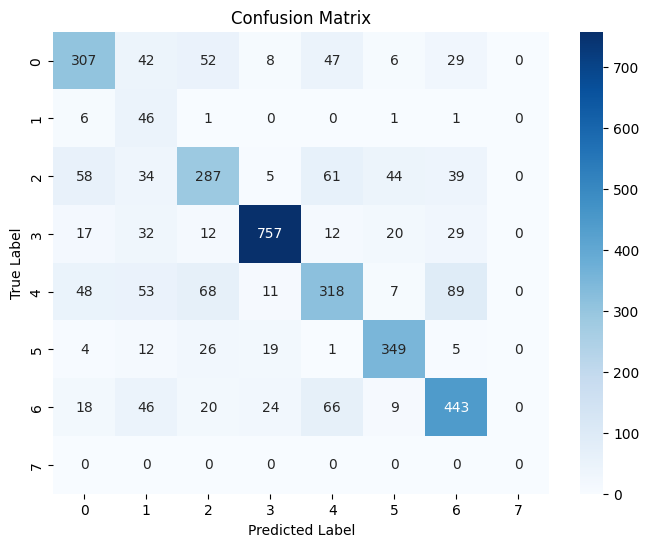

In [2]:
# data_directory = '../../Datasets/JAFFE_Structured'
# data_directory = '../../Datasets/FER_Structured'
# data_directory = '../../Datasets/RAF-DB_Structured'
# data_directory = '../../Datasets/CK+_Structured'
# data_directory = '../../Datasets/AffectNet_Structured'

data_directory = '../../Datasets/FER_Structured_Aligned'

# model_path = 'ModelsReadyForComparison/EmoNeXt_RAF-DB_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt'
# model_path = 'ModelsReadyForComparison/EmoNeXt_FER_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt'
# model_path = 'ModelsReadyForComparison/EmoNeXt_AffectNet_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt'
model_path = 'Models/EmoNeXt_FER_Aligned_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt'

base_model_size = 'small'
base_model_in_22k = True

TestEmoNeXt(data_directory, model_path, base_model_size, base_model_in_22k, batch_size=32)